## Trend filtering after spatial denoising

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from trendFiltering.trendfilter import TF, TFsafe

### Simulated data

In [25]:
xp = np.array([1, 100, 150, 260, 300, 350, 400], dtype='float64')
yp = np.array([3, 10, -2, -5, 9, 2, 6], dtype='float64')
x = np.linspace(1, 400, num=400)
spl = sp.interpolate.splrep(xp, yp)
y = sp.interpolate.splev(x, spl)
y = y + np.random.normal(size = y.shape)*5

---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
   1  1.32e+04   267  2.45e+03   128   142   129
   2  1.89e+03   158  2.50e+02    64   287    48
   3  1.84e+03    94  1.39e+02    62   269    68
   4  1.59e+03    48  5.83e+01    70   271    58
   5  1.59e+03    19  4.05e+01    72   269    58
   6  1.29e+03     9  8.38e+00    63   280    56
   7  1.21e+03     1  6.34e-02    59   289    51
   8  1.21e+03     0  0.00e+00    58   290    51
---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
   1  4.85e+04   274  4.64e+03   136   123   140
   2  2.87e+03   121  2.22e+02    38   315    46
   3  3.83e+03   103  2.50e+02    44   294    61
   4  3.28e+03    52  1.29e+02    55   291    53
   5  1.64e+03    23  4.10e+01    43   317    39
   6  1.04e+03    15  9.39e+00    35   340    24
   7  1.

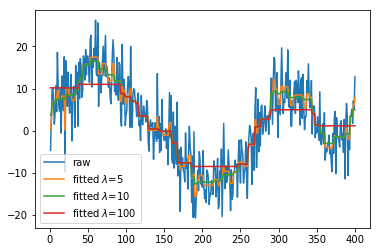

In [43]:
plt.plot(x, y, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob = TFsafe(y[:,np.newaxis],lam,order=1,mode = -1)
    prob.pdas()
    plt.plot(x, prob.x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()

### Load TK's data

In [48]:
cropSDN = sp.io.loadmat('cropSDN.mat')['cropSDN'][0]

---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
   1  5.43e+04  1310  1.06e+04   684   679   637
   2  2.37e+03   800  9.12e+02   165  1697   138
   3  4.61e+03   696  7.64e+02   454  1297   249
   4  3.66e+03   469  4.65e+02   376  1315   309
   5  2.24e+03   224  1.63e+02   261  1466   273
   6  1.05e+03   109  4.02e+01   180  1644   176
   7  8.87e+02    33  1.63e+01   144  1693   163
   8  7.77e+02    13  4.83e+00   137  1720   143
   9  7.38e+02     5  9.48e-01   134  1731   135
  10  7.30e+02     1  1.10e-02   133  1734   133
  11  7.30e+02     0  0.00e+00   133  1733   134
---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
   1  2.13e+05  1329  2.10e+04   644   680   676
   2  9.16e+03   634  9.49e+02   173  1639   188
   3  6.19e+03   693  8.03e+02   162  1551   287
   4  8.

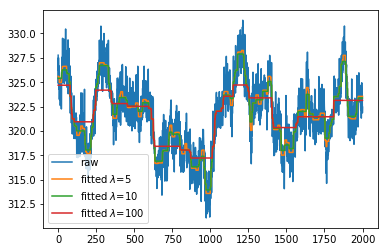

In [54]:
x = np.arange(cropSDN.shape[0])
plt.plot(x, cropSDN, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob = TFsafe(cropSDN[:,np.newaxis],lam,order=1,mode = -1)
    prob.pdas()
    plt.plot(x, prob.x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()